# PCA analysis of TCGA-BRCA multi-omics data

- Load mRNA, DNAm, RPPA data and PAM50 labels  
- Compute sample overlaps  
- Run PCA per view and combined PCA  
- Visualize PCs (2D/3D) with PAM50 coloring  
- Quantify separation with silhouette scores (overall & pairwise)  
- Quantify variance explained per view vs number of dimensions  
- Prepare placeholders for MOFA comparison


In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from helpers import *

sns.set(style="whitegrid")


In [2]:
data_dir = "./../data/TCGA-BRCA/"
mods = ["mRNA", "DNAm", "RPPA"]

data = {}
for omic in mods:
    with open(f"{data_dir}{omic}.pkl", "rb") as f:
        data[omic] = pickle.load(f)

list(data.keys())


C:\Users\Petar\AppData\Local\Temp\ipykernel_27944\2711072643.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data[omic] = pickle.load(f)
C:\Users\Petar\AppData\Local\Temp\ipykernel_27944\2711072643.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access

['mRNA', 'DNAm', 'RPPA']

In [3]:
idx_rna  = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)

patients_intersection = sorted(idx_rna & idx_meth & idx_prot)

print(f"mRNA samples: {len(idx_rna)}")
print(f"DNAm samples: {len(idx_meth)}")
print(f"RPPA samples: {len(idx_prot)}")
print(f"Intersection (all three): {len(patients_intersection)}")


mRNA samples: 500
DNAm samples: 500
RPPA samples: 500
Intersection (all three): 401


In [4]:
def get_pam50(view_name: str) -> pd.Series:
    meta = data[view_name].get("meta", None)
    if meta is None or "paper_BRCA_Subtype_PAM50" not in meta.columns:
        return pd.Series(index=[], dtype="object")
    s = meta["paper_BRCA_Subtype_PAM50"].astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    s.name = view_name
    return s

pam_rna  = get_pam50("mRNA")
pam_meth = get_pam50("DNAm")
pam_prot = get_pam50("RPPA")

pam_df = pd.concat([pam_rna, pam_meth, pam_prot], axis=1)
pam_df.columns = ["mRNA", "DNAm", "RPPA"]
pam_df = pam_df.reindex(patients_intersection)
pam_df.head()


,mRNA,DNAm,RPPA
TCGA-3C-AALI,Her2,Her2,Her2
TCGA-4H-AAAK,LumA,LumA,LumA
TCGA-5L-AAT1,LumA,LumA,LumA
TCGA-A1-A0SF,LumA,LumA,LumA
TCGA-A1-A0SH,LumA,LumA,LumA


### MOFA - training

### Top variable features 2000/2000/464 - Training

In [17]:
views_to_use = ["mRNA", "DNAm", "RPPA"]  # or whatever your keys are

filtered_data, selected_features = select_top_variable_features(
    data,
    n_keep=2000,
    views=views_to_use,
    use="var"   # or "mad" if you prefer
)

mRNA: kept 2000 / 29995 features
DNAm: kept 2000 / 100000 features
RPPA: kept 464 / 464 features


In [20]:
dna = filtered_data['DNAm']['expr']
rna = filtered_data['mRNA']['expr']
rppa = filtered_data['RPPA']['expr']
all_samples = dna.index.union(rna.index).union(rppa.index)

In [21]:
dna = dna.reindex(all_samples)
rna = rna.reindex(all_samples)
rppa = rppa.reindex(all_samples)

In [23]:
import scanpy as sc
import muon as mu
import mofax as mofa


mods = {
    "dna": sc.AnnData(dna),
    "rna": sc.AnnData(rna),
    "rppa": sc.AnnData(rppa)
}

print(mods['dna'].obs.shape)
print(mods['rna'].obs.shape)
print(mods['rppa'].obs.shape)
print(mods["dna"].obs[:5])
print("\n")
print(mods['dna'].var.shape)
print(mods['rna'].var.shape)
print(mods['rppa'].var.shape)
print(mods['dna'].var[:5])
print("\n")
print(mods['dna'].X.shape)
print(mods['rna'].X.shape)
print(mods['rppa'].X.shape)
print(mods['dna'].X[:5])

print(mods['dna'].obs_names.shape)

(658, 0)
(658, 0)
(658, 0)
Empty DataFrame
Columns: []
Index: [TCGA-3C-AALI, TCGA-3C-AALJ, TCGA-3C-AALK, TCGA-4H-AAAK, TCGA-5L-AAT1]


(2000, 0)
(2000, 0)
(464, 0)
Empty DataFrame
Columns: []
Index: [cg11738485, cg01893212, cg21885317, cg12466610, cg22473620]


(658, 2000)
(658, 2000)
(658, 464)
[[0.02145294 0.21287052 0.95111028 ... 0.01541674 0.94935159 0.53761163]
 [0.02371688 0.46608865 0.61520572 ... 0.30738021 0.95676467 0.63558531]
 [0.60196534 0.60192856 0.15753967 ... 0.46131341 0.42550215 0.46845057]
 [0.46182789 0.75570561 0.86500181 ... 0.54197607 0.82132093 0.05166112]
 [0.97271683 0.57248728 0.2921947  ... 0.389175   0.85455203 0.56879577]]
(658,)


C:\Users\Petar\anaconda3\Lib\site-packages\muon\_core\preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [24]:
mdata = mu.MuData(mods)

C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
C:\Users\Petar\anaconda3\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [26]:
index = mdata.obs_names  # same as all_samples

meta_dna  = data['DNAm']['meta'].reindex(index)
meta_rna  = data['mRNA']['meta'].reindex(index)
meta_rppa = data['RPPA']['meta'].reindex(index)

meta = pd.concat([meta_dna, meta_rna, meta_rppa], axis=1)
meta = meta.loc[:, ~meta.columns.duplicated()]
mdata.obs = meta
mdata

MuData object with n_obs × n_vars = 658 × 4464
  obs:	'patient', 'race', 'gender', 'sample_type', 'paper_BRCA_Subtype_PAM50', 'sizeFactor', 'replaceable'
  3 modalities
    dna:	658 x 2000
    rna:	658 x 2000
    rppa:	658 x 464

In [29]:
mu.tl.mofa(mdata, 
            use_obs='union',
            n_factors=15,
            convergence_mode='medium',
            outfile="exports/most_variable.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='dna' group='group1' with N=658 samples and D=2000 features...
Loaded view='rna' group='group1' with N=658 samples and D=2000 features...
Loaded view='rppa' group='group1' with N=658 samples and D=464 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-s

### Top variable features - 2000/2000/464 LOAD

In [51]:
model = mofa.mofa_model("exports/most_variable.hdf5")
model

MOFA+ model: most variable
Samples (cells): 658
Features: 4464
Groups: group1 (658)
Views: dna (2000), rna (2000), rppa (464)
Factors: 15
Expectations: W, Z

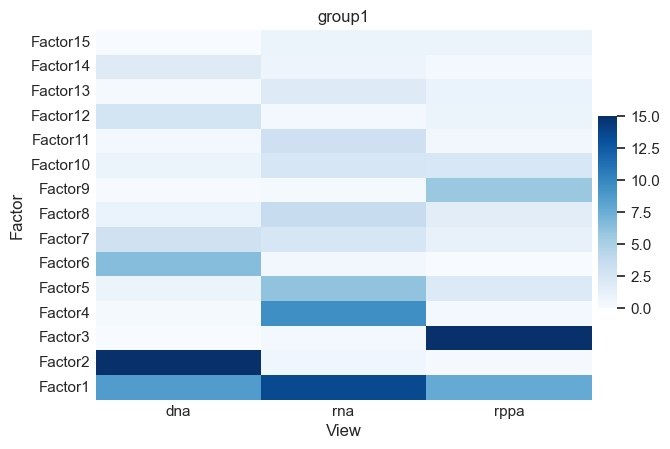

In [52]:
mofa.plot_r2(model, x='View', vmax=15)

In [53]:
x = mdata.obsm["X_mofa"]
x.shape

(658, 15)

In [73]:
X_mofa = mdata.obsm["X_mofa"]           # shape (N_all, 15)

mofa_scores = pd.DataFrame(
    X_mofa,
    index=mdata.obs.index,              # sample IDs
    columns=[f"PC{i+1}" for i in range(X_mofa.shape[1])]  # treat factors as PC1..PC15
)

mofa_scores.shape
mofa_scores_f = mofa_scores.copy()
mofa_scores_f.columns = [f"Factor{i+1}" for i in range(X_mofa.shape[1])]
pam_mofa = pam_df["mRNA"].rename("PAM50_RNA")  # or any column you prefer
pam_mofa.shape

(401,)

In [75]:
# pam_mofa already has length 401
# make sure we only keep samples that exist in both objects
common = mofa_scores.index.intersection(pam_mofa.index)

mofa_scores_401 = mofa_scores.loc[common]
pam_mofa_401    = pam_mofa.loc[common]

mofa_scores_401.shape, pam_mofa_401.shape


((401, 15), (401,))

In [ ]:
X_mofa_inter = 

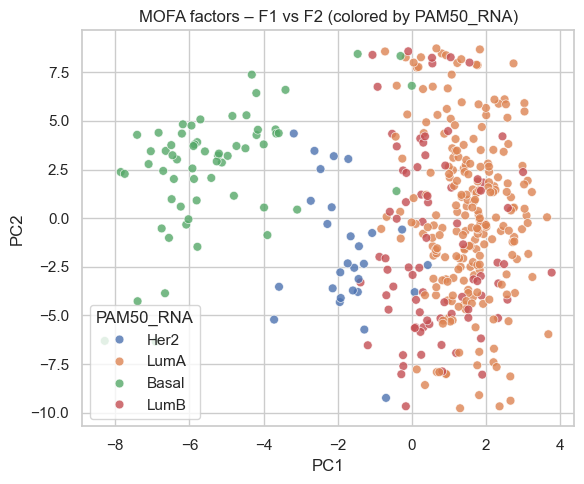

In [43]:
plot_pca_2d(
    mofa_scores,
    labels=pam_mofa,
    x_pc=1,
    y_pc=2,
    title="MOFA factors – F1 vs F2 (colored by PAM50_RNA)",
)


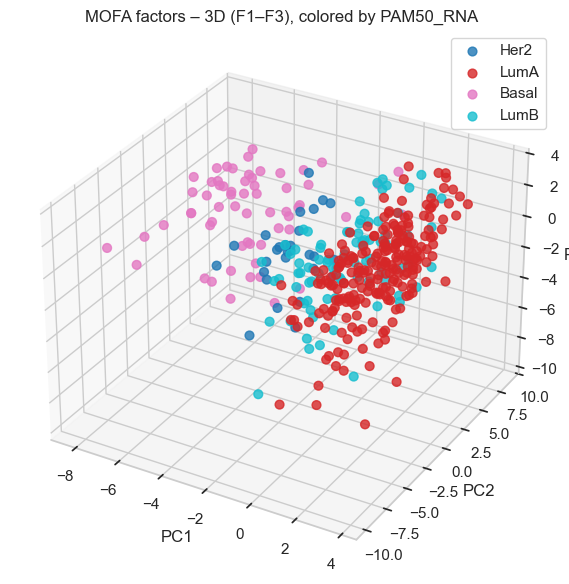

In [44]:
plot_pca_3d(
    mofa_scores,
    labels=pam_mofa,
    pcs=(1, 2, 3),
    title="MOFA factors – 3D (F1–F3), colored by PAM50_RNA",
)


### PCA


In [5]:
K = 100

pca_rna,  scores_rna,  load_rna  = run_pca_view(data, "mRNA", patients_intersection, K)
pca_meth, scores_meth, load_meth = run_pca_view(data, "DNAm", patients_intersection, K)
pca_prot, scores_prot, load_prot = run_pca_view(data, "RPPA", patients_intersection, K)


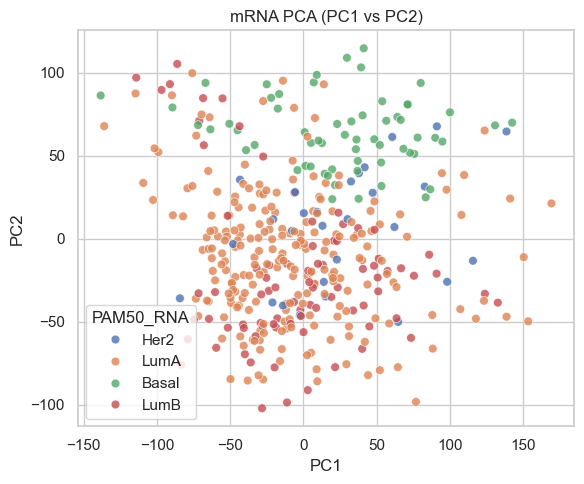

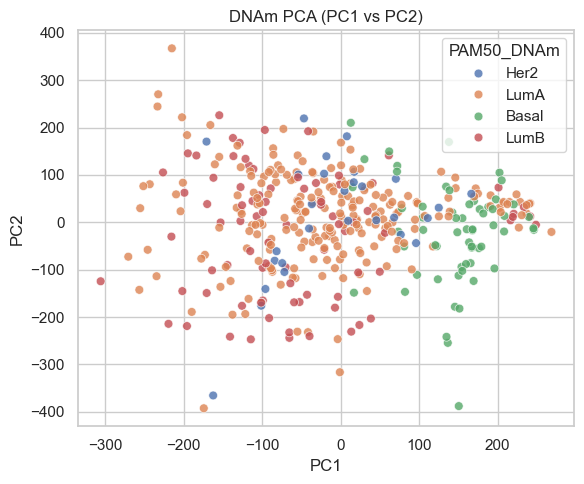

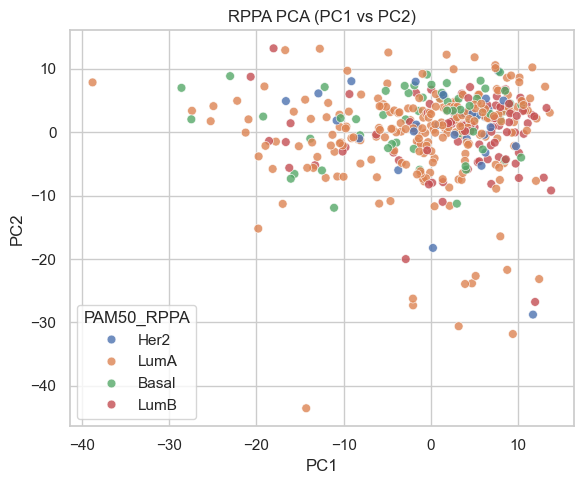

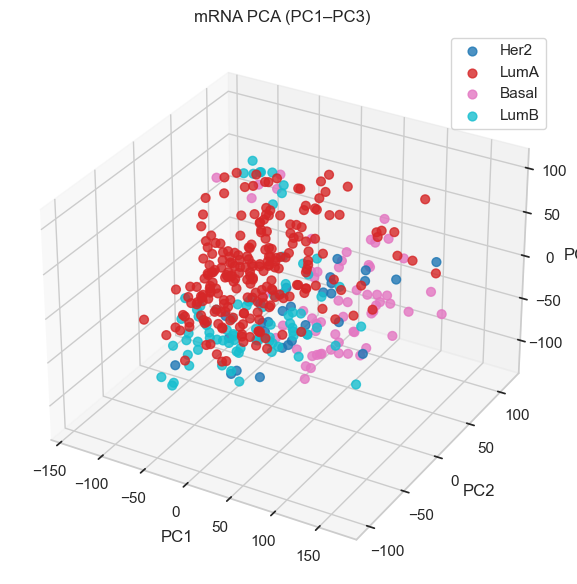

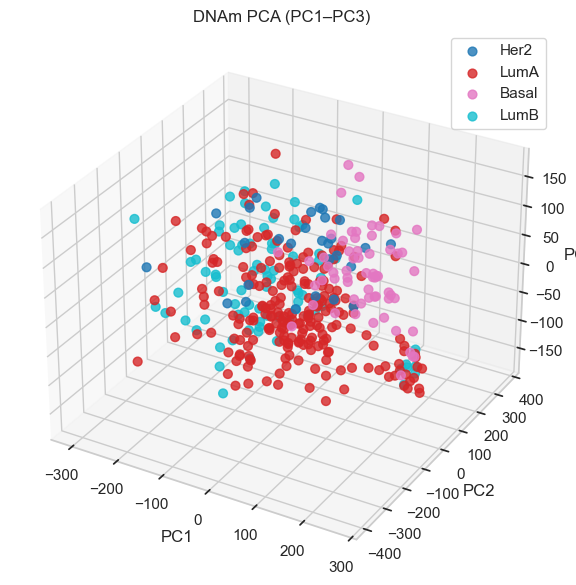

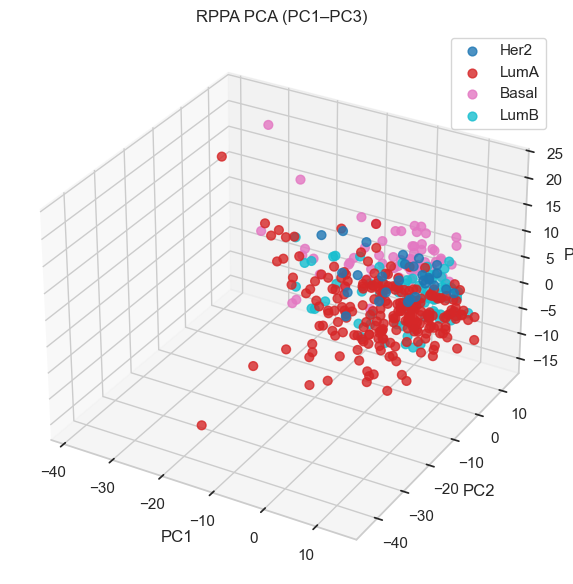

In [6]:
pam_rna_int  = pam_df["mRNA"].rename("PAM50_RNA")
pam_meth_int = pam_df["DNAm"].rename("PAM50_DNAm")
pam_prot_int = pam_df["RPPA"].rename("PAM50_RPPA")

# 2D
plot_pca_2d(scores_rna,  pam_rna_int,  title="mRNA PCA (PC1 vs PC2)")
plot_pca_2d(scores_meth, pam_meth_int, title="DNAm PCA (PC1 vs PC2)")
plot_pca_2d(scores_prot, pam_prot_int, title="RPPA PCA (PC1 vs PC2)")

# 3D
plot_pca_3d(scores_rna,  pam_rna_int,  title="mRNA PCA (PC1–PC3)")
plot_pca_3d(scores_meth, pam_meth_int, title="DNAm PCA (PC1–PC3)")
plot_pca_3d(scores_prot, pam_prot_int, title="RPPA PCA (PC1–PC3)")


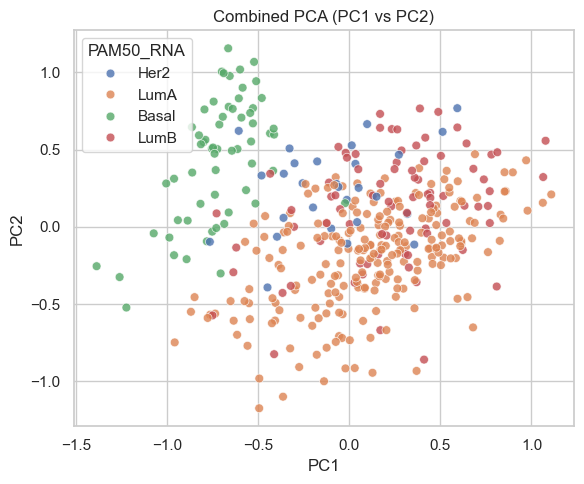

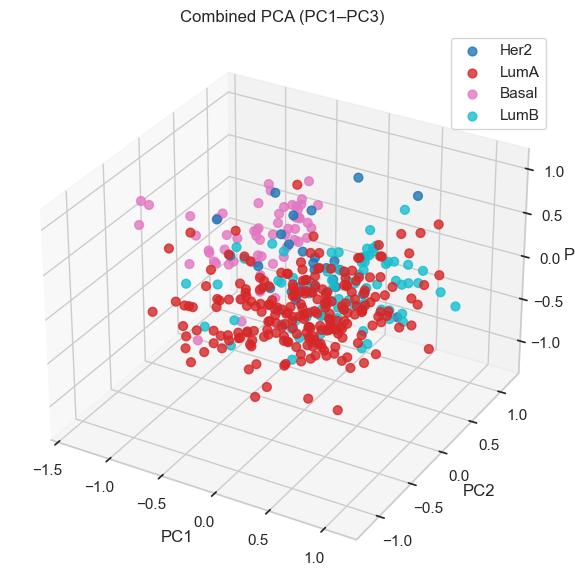

In [7]:
K_comb = 100
X_concat = get_concat_matrix(data, patients_intersection)

from sklearn.decomposition import PCA
pca_combined = PCA(n_components=K_comb, random_state=0)
scores_combined = pd.DataFrame(
    pca_combined.fit_transform(X_concat.values),
    index=X_concat.index,
    columns=[f"PC{i+1}" for i in range(K_comb)],
)

pam_comb = pam_df["mRNA"].rename("PAM50_RNA")
plot_pca_2d(scores_combined, pam_comb, title="Combined PCA (PC1 vs PC2)")
plot_pca_3d(scores_combined, pam_comb, title="Combined PCA (PC1–PC3)")


### Silhouette score: measuring cluster separation

To quantify how well the PAM50 subtypes are separated in a given embedding
(e.g. PCA or MOFA factors), we use the **silhouette score**.

For each sample $i$ we compute:

- $a(i)$: the average distance from $i$ to all other samples **in the same class**  
- $b(i)$: the smallest average distance from $i$ to samples in any **different class**  
  (i.e. the closest *other* cluster)

The silhouette value for sample $i$ is defined as

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i),\, b(i)\}} \in [-1, 1].
$$

Interpretation:

- $s(i) \approx 1$: sample is **much closer to its own class** than to other classes  
  $\Rightarrow$ well assigned and well separated.
- $s(i) \approx 0$: sample lies **near the boundary** between clusters.
- $s(i) < 0$: sample is, on average, **closer to another class** than to its own  
  $\Rightarrow$ possibly misclustered (or the embedding does not reflect the labels well).

The **overall silhouette score** is the mean of $s(i)$ over all samples:

$$
\text{Silhouette} = \frac{1}{N} \sum_{i=1}^N s(i).
$$

- Values closer to **1** indicate that the labeled groups (here: PAM50 subtypes)
  form **well separated clusters** in the chosen low-dimensional space.
- Values around **0** indicate **weak or no clear separation**.
- Negative values indicate that many samples are **closer to other clusters**
  than to their own, suggesting poor agreement between the embedding and the labels.


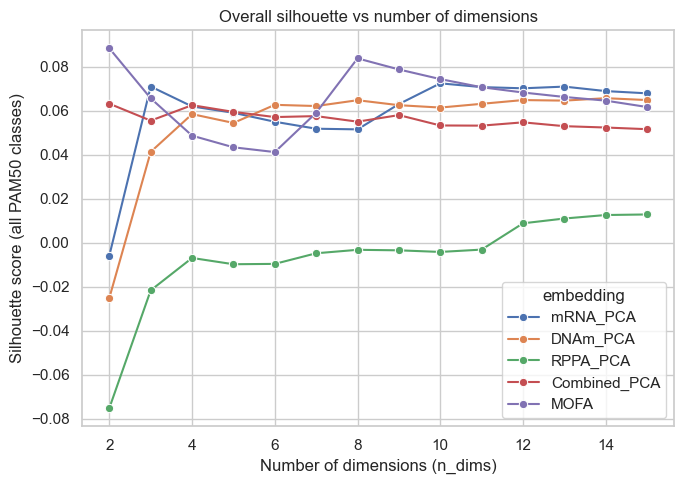

In [45]:
embeddings = {
    "mRNA_PCA":     scores_rna,
    "DNAm_PCA":     scores_meth,
    "RPPA_PCA":     scores_prot,
    "Combined_PCA": scores_combined,
    "MOFA":         mofa_scores,
}

pam_rna_nonnull = pam_df["mRNA"].dropna()
dims = range(2, 16)

overall_sil = pd.DataFrame(index=embeddings.keys(), columns=dims, dtype=float)
for d in dims:
    for name, Z in embeddings.items():
        overall_sil.loc[name, d] = silhouette_in_embedding(Z, pam_rna_nonnull, n_dims=d)

overall_sil_long = (
    overall_sil.T
    .reset_index()
    .melt(id_vars="index", var_name="embedding", value_name="silhouette")
    .rename(columns={"index": "n_dims"})
)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=overall_sil_long,
    x="n_dims",
    y="silhouette",
    hue="embedding",
    marker="o",
)
plt.title("Overall silhouette vs number of dimensions")
plt.xlabel("Number of dimensions (n_dims)")
plt.ylabel("Silhouette score (all PAM50 classes)")
plt.tight_layout()
plt.show()


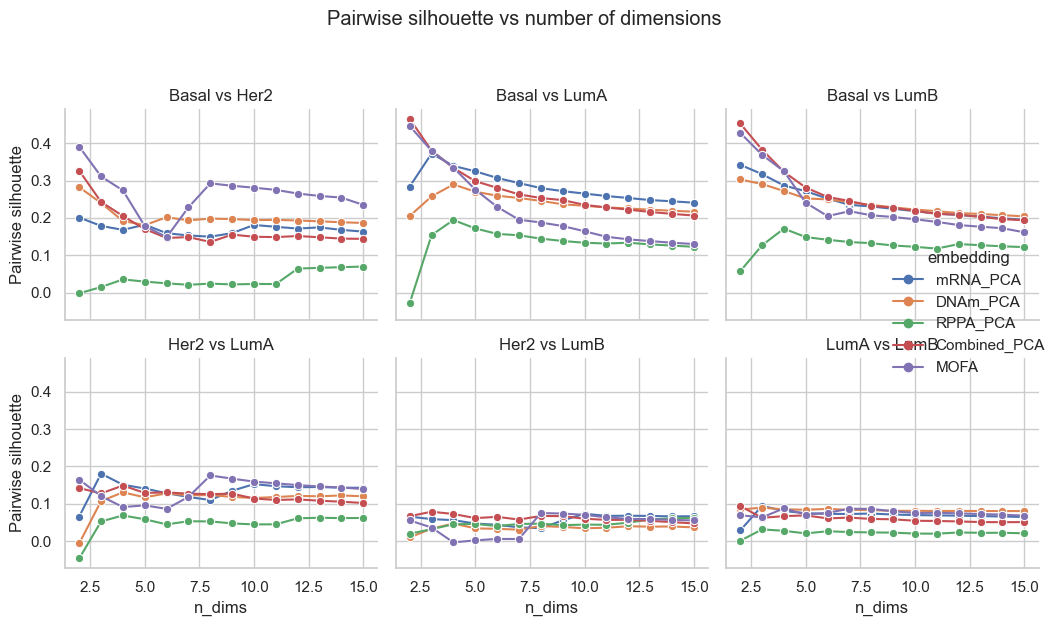

In [46]:
dims = range(2, 16)

pairwise_by_dim = {}
for d in dims:
    pairwise_by_dim[d] = pairwise_silhouette_views(embeddings, pam_rna_nonnull, n_dims=d)

pairwise_panel = pd.concat(pairwise_by_dim, names=["n_dims", "embedding"])

pairwise_long = (
    pairwise_panel
    .reset_index()
    .melt(id_vars=["n_dims", "embedding"], var_name="pair", value_name="silhouette")
)

g = sns.relplot(
    data=pairwise_long,
    x="n_dims",
    y="silhouette",
    hue="embedding",
    col="pair",
    kind="line",
    marker="o",
    col_wrap=3,
    height=3,
    facet_kws={"sharey": True, "sharex": True},
)
g.set_titles("{col_name}")
g.set_axis_labels("n_dims", "Pairwise silhouette")
plt.suptitle("Pairwise silhouette vs number of dimensions", y=1.04)
plt.tight_layout()
plt.show()


### Variance explained (R²) by an embedding

To quantify how well a low–dimensional embedding (PCA components or MOFA
factors) captures the variability of each omic view, we use a **variance
explained score** based on the coefficient of determination $R^2$.

Let

- $X \in \mathbb{R}^{N \times P}$ be the data matrix for one view  
  (e.g. mRNA expression: $N$ samples, $P$ features),
- $Z \in \mathbb{R}^{N \times K}$ be the embedding (scores) for the same
  samples, where $K$ is the number of components/factors we keep.

We first **center** the view:

$$
\tilde X = X - \bar X,
$$

where $\bar X$ is the column-wise mean of $X$.

Then we fit a linear reconstruction of $\tilde X$ from $Z$:

$$
\hat X = Z W^\top,
$$

where $W$ is obtained by least squares:

$$
W = \arg\min_W \;\lVert \tilde X - Z W^\top \rVert_F^2.
$$

The total variance explained by the embedding $Z$ in that view is

$$
R^2 = 1 - \frac{\sum_{i,j} (\tilde X_{ij} - \hat X_{ij})^2}
               {\sum_{i,j} (\tilde X_{ij})^2}.
$$

Interpretation:

- $R^2$ close to $1$ (or $100\%$) means that the low–dimensional
  representation $Z$ retains **most of the variability** of that view.
- $R^2$ close to $0$ means that $Z$ explains **very little** of the
  variance in that view.
- When we compute $R^2$ for different embeddings (e.g. mRNA PCA,
  combined PCA, MOFA) on the **same view**, we can compare how well
  each embedding preserves the structure of that omic.

In the per-factor heatmaps, we apply the same idea but use only a single
column of $Z$ (one component/factor) at a time, which tells us how much
variance each individual factor explains in each view.


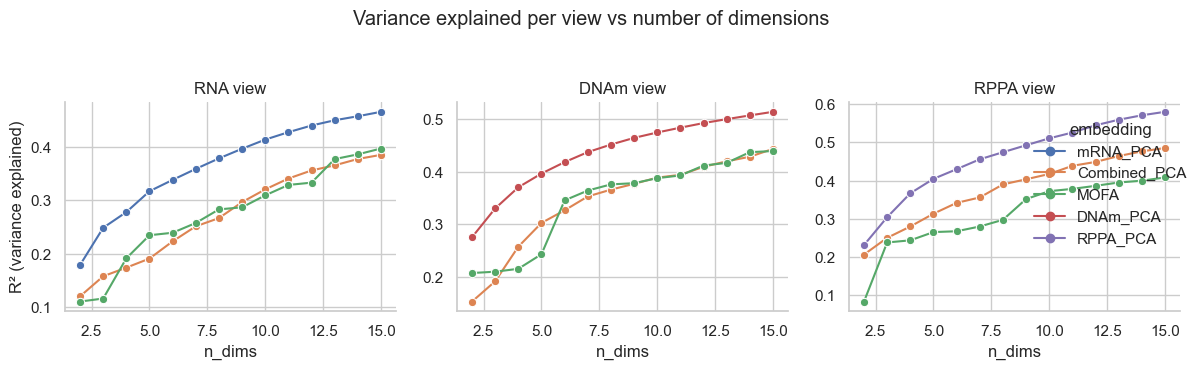

In [48]:
X_rna  = data["mRNA"]["expr"]
X_meth = data["DNAm"]["expr"]
X_prot = data["RPPA"]["expr"]

rows = []
dims = range(2, 16)

for d in dims:
    Z_rna_d  = scores_rna.iloc[:, :d]
    Z_meth_d = scores_meth.iloc[:, :d]
    Z_prot_d = scores_prot.iloc[:, :d]
    Z_comb_d = scores_combined.iloc[:, :d]
    Z_mofa_d = mofa_scores.iloc[:, :d]

    rows.append({"view": "RNA",  "embedding": "mRNA_PCA",   "n_dims": d,
                 "R2": variance_explained_view(X_rna, Z_rna_d)})
    rows.append({"view": "RNA",  "embedding": "Combined_PCA","n_dims": d,
                 "R2": variance_explained_view(X_rna, Z_comb_d)})
    rows.append({"view": "RNA",  "embedding": "MOFA",        "n_dims": d,
                 "R2": variance_explained_view(X_rna, Z_mofa_d)})

    rows.append({"view": "DNAm","embedding": "DNAm_PCA",    "n_dims": d,
                 "R2": variance_explained_view(X_meth, Z_meth_d)})
    rows.append({"view": "DNAm","embedding": "Combined_PCA","n_dims": d,
                 "R2": variance_explained_view(X_meth, Z_comb_d)})
    rows.append({"view": "DNAm","embedding": "MOFA",        "n_dims": d,
                 "R2": variance_explained_view(X_meth, Z_mofa_d)})

    rows.append({"view": "RPPA","embedding": "RPPA_PCA",    "n_dims": d,
                 "R2": variance_explained_view(X_prot, Z_prot_d)})
    rows.append({"view": "RPPA","embedding": "Combined_PCA","n_dims": d,
                 "R2": variance_explained_view(X_prot, Z_comb_d)})
    rows.append({"view": "RPPA","embedding": "MOFA",        "n_dims": d,
                 "R2": variance_explained_view(X_prot, Z_mofa_d)})

r2_df = pd.DataFrame(rows)

g = sns.relplot(
    data=r2_df,
    x="n_dims",
    y="R2",
    hue="embedding",
    col="view",
    kind="line",
    marker="o",
    col_wrap=3,
    height=3.5,
    facet_kws={"sharey": False, "sharex": True},
)
g.set_titles("{col_name} view")
g.set_axis_labels("n_dims", "R² (variance explained)")
plt.suptitle("Variance explained per view vs number of dimensions", y=1.05)
plt.tight_layout()
plt.show()


In [49]:
# Make sure these are restricted to the same patients (e.g. patients_intersection)
# If you followed the previous notebook structure, they already are.
views = {
    "dna":  X_meth,   # DNAm
    "ma":   X_rna,    # mRNA
    "rppa": X_prot,   # RPPA
}

embeddings = {
    "mRNA_PCA":     scores_rna,
    "DNAm_PCA":     scores_meth,
    "RPPA_PCA":     scores_prot,
    "Combined_PCA": scores_combined,
    "MOFA":         mofa_scores  # later, if you want to plot in same style
}


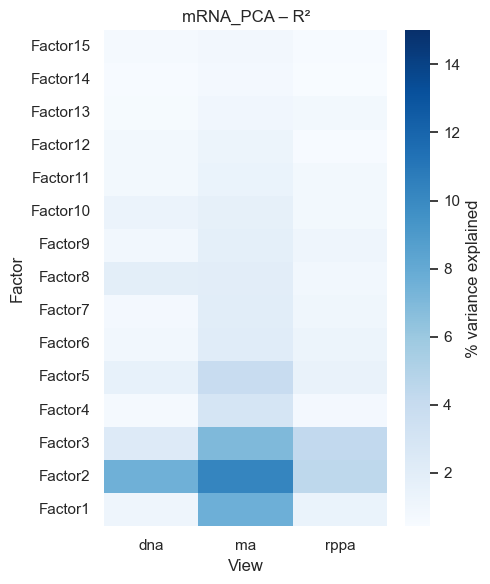

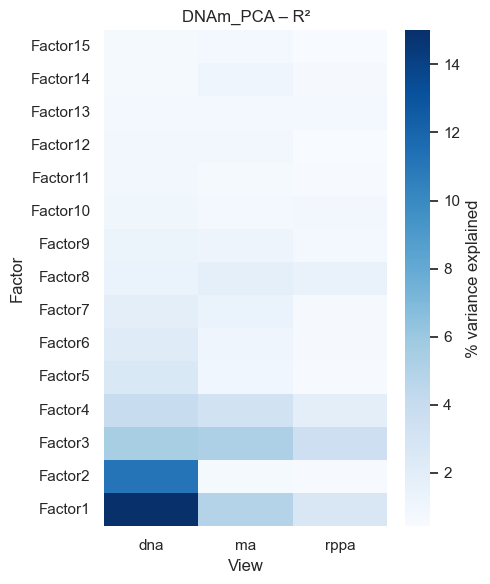

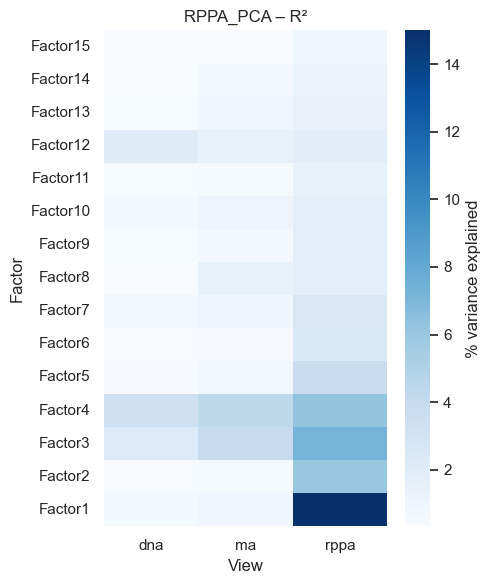

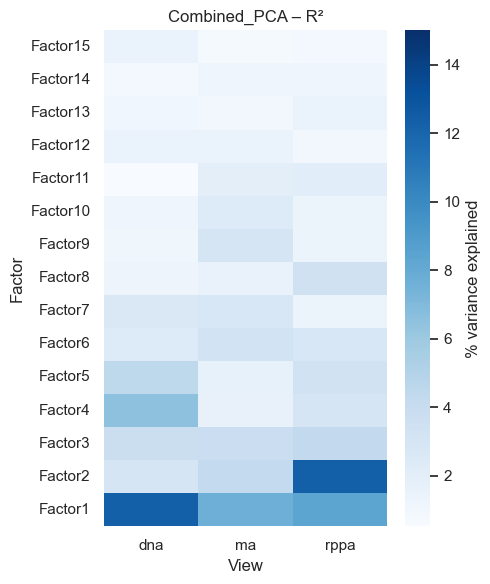

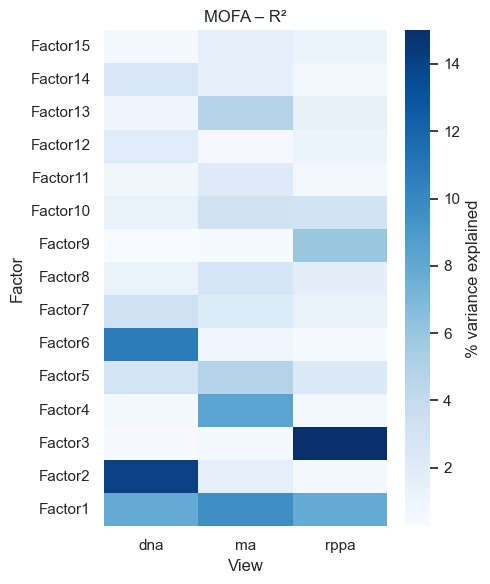

In [50]:
for emb_name, Z in embeddings.items():
    r2_mat = per_factor_r2_matrix(views, Z, n_factors=15)  # 15 to match MOFA
    # convert to percent like MOFA usually does
    r2_percent = 100 * r2_mat

    # reverse the order of factors so Factor1 is at the bottom
    r2_percent_inv = r2_percent.iloc[::-1]

    plt.figure(figsize=(5, 6))
    sns.heatmap(
        r2_percent_inv,
        cmap="Blues",
        vmax=15,
        cbar_kws={"label": "% variance explained"}
    )
    plt.title(f"{emb_name} – R²")
    plt.xlabel("View")
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()


### Using all patients

In [54]:
def get_pam50_raw(view_name: str) -> pd.Series:
    meta = data[view_name].get("meta", None)
    if meta is None or "paper_BRCA_Subtype_PAM50" not in meta.columns:
        return pd.Series(index=[], dtype="object")
    s = meta["paper_BRCA_Subtype_PAM50"].astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    s.name = view_name
    return s

pam_rna_full  = get_pam50_raw("mRNA")
pam_meth_full = get_pam50_raw("DNAm")
pam_prot_full = get_pam50_raw("RPPA")


In [55]:
pam_any = pam_rna_full.copy()
pam_any = pam_any.combine_first(pam_meth_full)
pam_any = pam_any.combine_first(pam_prot_full)
pam_any.name = "PAM50_any"


In [56]:
pam_mofa = pam_any.reindex(mofa_scores.index)
pam_mofa_nonnull = pam_mofa.dropna()
pam_mofa_nonnull.shape  # should be larger than 401

(658,)

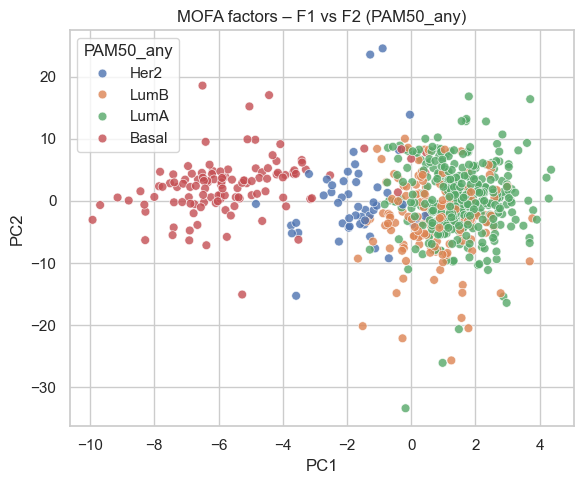

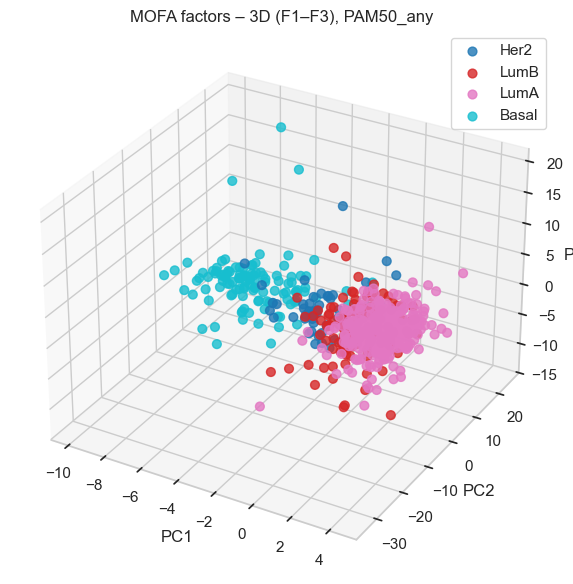

In [57]:
plot_pca_2d(
    mofa_scores,
    labels=pam_mofa,
    x_pc=1,
    y_pc=2,
    title="MOFA factors – F1 vs F2 (PAM50_any)",
)

plot_pca_3d(
    mofa_scores,
    labels=pam_mofa,
    pcs=(1, 2, 3),
    title="MOFA factors – 3D (F1–F3), PAM50_any",
)


### Initial classification

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'clf__C': 1, 'clf__penalty': 'l1'}
Balanced Acc: 0.824
ROC-AUC (OvR, weighted): 0.938
              precision    recall  f1-score   support

           0      0.920     0.958     0.939        24
           1      0.900     0.900     0.900        10
           2      0.841     0.829     0.835        70
           3      0.607     0.607     0.607        28

    accuracy                          0.811       132
   macro avg      0.817     0.824     0.820       132
weighted avg      0.810     0.811     0.810       132

Confusion matrix:
 [[23  0  1  0]
 [ 1  9  0  0]
 [ 0  1 58 11]
 [ 1  0 10 17]]


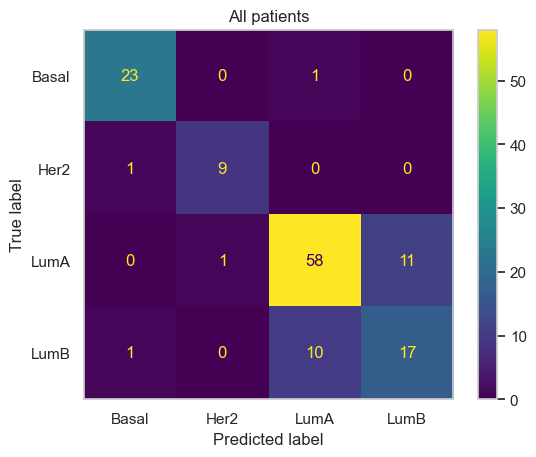

In [83]:
X = mofa_scores
y = pam_mofa_nonnull
y_str =y
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
le.fit(np.unique(y))
       
y = le.transform(y)

Xtr, Xte, ytr, yte = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)



clf = LogisticRegression(
    solver="saga",
    multi_class="multinomial",
    max_iter=5000,
    class_weight = 'balanced',
    n_jobs=-1,
    random_state=42
)

mofa_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100],
              "clf__penalty": ['l1', 'l2']}  

gs = GridSearchCV(mofa_pipeline, param_grid,
                  scoring="balanced_accuracy",
                  cv=cv, n_jobs=-1, verbose=2, refit=True)

gs.fit(Xtr, ytr)

print("Best params:", gs.best_params_)
y_pred = gs.predict(Xte)
proba  = gs.predict_proba(Xte)

print("Balanced Acc:", balanced_accuracy_score(yte, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(yte, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(yte, y_pred, digits=3)) 
print("Confusion matrix:\n", confusion_matrix(yte, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay

classes = np.unique(y_str)
cm = confusion_matrix(yte, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.title('All patients')
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'clf__C': 1, 'clf__penalty': 'l1'}
Balanced Acc: 0.776
ROC-AUC (OvR, weighted): 0.902
              precision    recall  f1-score   support

           0      0.923     1.000     0.960        12
           1      1.000     0.667     0.800         6
           2      0.848     0.848     0.848        46
           3      0.556     0.588     0.571        17

    accuracy                          0.802        81
   macro avg      0.832     0.776     0.795        81
weighted avg      0.809     0.802     0.803        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  4  0  2]
 [ 1  0 39  6]
 [ 0  0  7 10]]


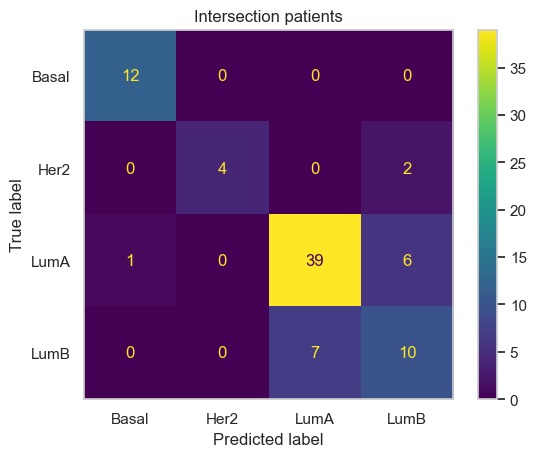

In [80]:
X = mofa_scores_401
y = pam_mofa_401
y_str =y
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
le.fit(np.unique(y))
       
y = le.transform(y)

Xtr, Xte, ytr, yte = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)


clf = LogisticRegression(
    solver="saga",
    multi_class="multinomial",
    max_iter=5000,
    class_weight = 'balanced',
    n_jobs=-1,
    random_state=42
)

mofa_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100],
              "clf__penalty": ['l1', 'l2']}  

gs = GridSearchCV(mofa_pipeline, param_grid,
                  scoring="balanced_accuracy",
                  cv=cv, n_jobs=-1, verbose=2, refit=True)

gs.fit(Xtr, ytr)

print("Best params:", gs.best_params_)
y_pred = gs.predict(Xte)
proba  = gs.predict_proba(Xte)

print("Balanced Acc:", balanced_accuracy_score(yte, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(yte, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(yte, y_pred, digits=3)) 
print("Confusion matrix:\n", confusion_matrix(yte, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay

classes = np.unique(y_str)
cm = confusion_matrix(yte, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.title('Intersection patients')
plt.show()
